In [2]:
%matplotlib inline
import sys,os
sys.path.append('/data/fragosta/work/lsst/sims_maf_contrib-master/')
import numpy as np
from sklearn.utils import shuffle
from scipy.stats import norm, uniform,ks_2samp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KernelDensity
from scipy.stats import *
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots
from lsst.sims.utils import equatorialFromGalactic, galacticFromEquatorial
from builtins import zip
from lsst.sims.maf.metrics import BaseMetric
from lsst.sims.maf.utils import m52snr, sigma_slope, astrom_precision
import glob
from opsimUtils import *
import astropy
from astropy.stats import bayesian_blocks
import time

In [3]:
your_username = 'fragosta'

In [4]:
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.4/'
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/test'.format(your_username)

if not os.path.exists(os.path.abspath(outDir)):
    os.mkdir(os.path.abspath(outDir))
    
dbRuns = show_opsims(dbDir)

In [5]:
# two dictionary are returned by the following function, 
# One (opSimDbs) is a dictionary storing all database objects
# Another (resultDbs) is a dictionary consist of the objects directing MAF where to save metric metadata
# Both dictionaries are indexed by OpSim run names
opSimDbs, resultDbs = connect_dbs(dbDir, outDir)

In [6]:
def readfile( filename='', colsname=['']):
        if 'csv' in filename:
            #print('reading {}'.format(filename))
            data = pd.read_csv(filename, header=0, names = colsname )
        elif 'fits' in filename:
            #print('reading {}'.format(filename))
            hdul = fits.open(filename)
            data = hdul[1].data
        elif ['txt', 'dat'] in filename:
            #print('reading {}'.format(filename))
            data = {k:[] for k in colsname}
            f = open(filename)
            righe = f.readlines()
            for line in righe:
                line.split()
                for i, k in enumerate(colsname):
                    data[k].append(float(line[i]))                
        elif 'json'in filename:
            print('not implemented to read .json extention')
        return data

In [7]:
import pandas as pd
#filename=['dataRPM.csv','dataHR.csv']
#colsname=[['Hg','g-r'],['g','g-r']]
#dataRPM = readfile(filename[0], colsname[0])
#dataMS = readfile(filename[1], colsname[1])
#RPM = pd.DataFrame({colsname[0][0]:dataRPM[colsname[0][0]][0:int(len(dataRPM[colsname[0][0]])/10)],colsname[0][1]:dataRPM[colsname[0][1]][0:int(len(dataRPM[colsname[0][1]])/10)]})
#MS = pd.DataFrame({colsname[1][0]:dataMS[colsname[1][0]][0:int(len(dataMS[colsname[1][0]])/10)],colsname[1][1]:dataMS[colsname[1][1]][0:int(len(dataMS[colsname[1][1]])/10)]})

filename = 'data.csv'
colsname=['RA', 'DEC','g','g-r','Hg','PM','deltaX']
data = readfile(filename, colsname)
transienobj= pd.DataFrame({'ra':data['RA'], 'dec':data['DEC']})



In [8]:
class confusionmetric(BaseMetric):
    def __init__(self, filename = 'data.csv', colsname=['RA', 'DEC','g','g-r','Hg','PM', 'deltaX'], snr_lim=5,mode=None, MagIterLim=[0,1,1], surveyduration=10, metricName='confusionmetric',m5Col='fiveSigmaDepth', 
                 mjdCol='observationStartMJD',filterCol='filter', seeingCol='seeingFwhmGeom',dataout=True,**kwargs):
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.seeingCol = seeingCol
        self.filterCol = filterCol
        self.colsname = colsname
        self.snr_lim = snr_lim
        self.filename = filename 
        self.dataout = dataout
        self.mode = mode
        self.MagIterLim = MagIterLim
        self.surveyduration = surveyduration
        # to have as output all the simulated observed data set dataout=True, otherwise the relative error for 
        # each helpix is estimated
        if self.dataout:
            super(confusionmetric, self).__init__(col=[self.mjdCol,self.filterCol, self.m5Col,self.seeingCol,"night"],metricDtype='object', units='', metricName=metricName,
                                                 **kwargs)
        else:
            super(confusionmetric, self).__init__(col=[self.mjdCol,self.filterCol,  self.m5Col,self.seeingCol,"night"],
                                                       units='', metricDtype='float',metricName=metricName,
                                                        **kwargs)
    def readfile( filename='', colsname=['']):
        if 'csv' in filename:
            #print('reading {}'.format(filename))
            data = pd.read_csv(filename, header=0, names = colsname )
        elif 'fits' in filename:
            #print('reading {}'.format(filename))
            hdul = fits.open(filename)
            data = hdul[1].data
        elif ['txt', 'dat'] in filename:
            #print('reading {}'.format(filename))
            data = {k:[] for k in colsname}
            f = open(filename)
            righe = f.readlines()
            for line in righe:
                line.split()
                for i, k in enumerate(colsname):
                    data[k].append(float(line[i]))                
        elif 'json'in filename:
            print('not implemented to read .json extention')
        return data
    def run(self, dataSlice, slicePoint=None):
        
        colsname=['RA', 'DEC','g','g-r','Hg','PM','deltaX']
        data = readfile(self.filename, self.colsname)
        obs = np.where(dataSlice[self.mjdCol]<min(dataSlice[self.mjdCol])+365*self.surveyduration)
        m5 = dataSlice[self.m5Col][obs]
        seeing= dataSlice[self.seeingCol][obs]
        filters = dataSlice['filter'][obs]
        g = np.array(data[self.colsname[2]])
        Hg = np.array(data[self.colsname[4]])
        gr = np.array(data[self.colsname[3]])
        ID = np.isclose(np.radians(data[self.colsname[0]]),slicePoint['ra'],rtol=1e-5)& np.isclose(np.radians(data[self.colsname[1]]),slicePoint['dec'],rtol=1e-5)
        pm = np.array(data[self.colsname[5]])*1e-3
        #deltaX = np.array(data[self.colsname[6]])*1e-3
        #deltaT = deltaX/pm
        deltamag= np.arange(self.MagIterLim[0],self.MagIterLim[1],self.MagIterLim[2])
        #tf = see[np.where(filters==self.colsname[2])]
        #dT = np.absolute(tf - shuffle(tf))/365.
        #IDtime = np.isclose(dT,deltaT[ID], rtol=1e-3)
        #T = np.median(dT[IDtime]) 
        #sigmadT = deltaT[ID] - T
        out = {}
        fwhm = {}
        mag_lim = np.median(m5[np.where(filters==self.colsname[2])])
        for dm in deltamag:
            mag= g[ID]+dm
            snr = m52snr(mag,mag_lim)
            if self.mode == 'distance':
                pmnew= pm/(10**(dm/5))
            elif self.mode == 'density':
                pmnew= pm
            else:
                print('##### ERROR: the metric is not implemented for this mode.')
            s=np.median(seeing)
            sigmafw=0.67*s
            coeff= np.log(10)*5
            deltaX= pmnew[ID]*self.surveyduration
            if snr>self.snr_lim and deltaX > 0.05*s:
                sigmaHg=np.sqrt(snr**(-2)*(1+(sigmafw*coeff/pmnew[ID]/self.surveyduration)**2))#+(coeff*sigmadT)**2)
                good_Hg = np.size(np.where((Hg>Hg[ID]-sigmaHg) &(Hg< Hg[ID]+sigmaHg)))/np.size(Hg)
                good_gr = np.size(np.where((gr>gr[ID]-snr**(-1)) &(gr<gr[ID]+snr**(-1))))/np.size(Hg)
                if good_Hg==good_gr:
                    good = good_Hg
                else:
                    good = max([good_Hg,good_gr])
            else:
                good = 0
            out[dm] = {'num':good, 'Hg': Hg[ID],'g-r': gr[ID]}
            fwhm[dm] = snr
        print(out)
        if self.dataout:
            return out 
        else:
            DM = np.array([out[dm]['num'] for dm in out.keys()])
            weight = 1/np.array([fwhm[dm] for dm in fwhm.keys()])**2
            alpha = DM[np.where(DM !=0)]*weight[np.where(DM !=0)]/weight[np.where(DM !=0)].sum()
            return alpha.sum()
        
        
        

In [109]:
#metric = TransienPM(Mmin=18,Mmax=24,f='g',m5Col='fiveSigmaDepth', mjdCol='observationStartMJD', seeingCol='seeingFwhmGeom', nexp= 10)
metric = confusionmetric(filename='data.csv', colsname=['RA', 'DEC','g','g-r','Hg','PM','deltaX'],snr_lim=5,mode='distance', surveyduration = 5, MagIterLim=[0,4,1],m5Col='fiveSigmaDepth', mjdCol='observationStartMJD',filterCol='filter', seeingCol='seeingFwhmGeom',dataout=True)
#slicer = slicers.HealpixSlicer(nside=8)
slicer = slicers.UserPointsSlicer(transienobj['ra'], transienobj['dec'])
sqlconstraint = ''# and note not like "DD%"'
metricSky = metricBundles.MetricBundle(metric,slicer,sqlconstraint)
bundleDict={'TransienPM':metricSky}


In [9]:
runs = [k for k in dbRuns if 'wfd_depth' in k]

In [10]:
runs

['wfd_depth_scale0.85_noddf_v1.4_10yrs',
 'wfd_depth_scale0.99_v1.4_10yrs',
 'wfd_depth_scale0.70_noddf_v1.4_10yrs',
 'wfd_depth_scale0.95_noddf_v1.4_10yrs',
 'wfd_depth_scale0.65_v1.4_10yrs',
 'wfd_depth_scale0.80_v1.4_10yrs',
 'wfd_depth_scale0.85_v1.4_10yrs',
 'wfd_depth_scale0.90_v1.4_10yrs',
 'wfd_depth_scale0.95_v1.4_10yrs',
 'wfd_depth_scale0.70_v1.4_10yrs',
 'wfd_depth_scale0.90_noddf_v1.4_10yrs',
 'wfd_depth_scale0.75_noddf_v1.4_10yrs',
 'wfd_depth_scale0.75_v1.4_10yrs',
 'wfd_depth_scale0.99_noddf_v1.4_10yrs',
 'wfd_depth_scale0.65_noddf_v1.4_10yrs',
 'wfd_depth_scale0.80_noddf_v1.4_10yrs']

In [110]:
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/test'.format(your_username)

# below I am only going to run metrics on the first five opsims
for i, run in enumerate(dbRuns[0:4]):
    print('##############\n')
    print('N_{}, {} is running\n'.format(i+1,run))
    print('##############\n')
    start_time = time.time()
    # must set run name for each opSim to store metric data into
    # separate files
    metricSky.setRunName(run)
    #metricSky2.setRunName(run)
    group = metricBundles.MetricBundleGroup(bundleDict, opSimDbs[run], metricDataPath, resultDbs[run])
    group.runAll()
    print("--- %s seconds ---\n" % (time.time() - start_time))
    print('####################\n')

##############

N_1, wfd_depth_scale0.85_noddf_v1.4_10yrs is running

##############

Querying database SummaryAllProps with no constraint for columns ['night', 'seeingFwhmGeom', 'filter', 'fieldDec', 'fieldRA', 'fiveSigmaDepth', 'observationStartMJD'].
Found 2178260 visits
Running:  ['TransienPM']
{0: {'num': 0, 'Hg': array([7.41185677]), 'g-r': array([0.825])}, 1: {'num': 0, 'Hg': array([7.41185677]), 'g-r': array([0.825])}, 2: {'num': 0, 'Hg': array([7.41185677]), 'g-r': array([0.825])}, 3: {'num': 0, 'Hg': array([7.41185677]), 'g-r': array([0.825])}}
{0: {'num': 0, 'Hg': array([9.60621298]), 'g-r': array([-0.221])}, 1: {'num': 0, 'Hg': array([9.60621298]), 'g-r': array([-0.221])}, 2: {'num': 0, 'Hg': array([9.60621298]), 'g-r': array([-0.221])}, 3: {'num': 0, 'Hg': array([9.60621298]), 'g-r': array([-0.221])}}
{0: {'num': 0, 'Hg': array([11.17726923]), 'g-r': array([1.3])}, 1: {'num': 0, 'Hg': array([11.17726923]), 'g-r': array([1.3])}, 2: {'num': 0, 'Hg': array([11.17726923]), 'g-

In [111]:
#resultDbPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData'.format(your_username)
# get a dictionary of resultDb from given directory
resultDbs2 = getResultsDbs(outDir)

# the following line will be useful if you did not run MAF on all 75 opsims
runNames = list(resultDbs2.keys())
bundleDicts = {}
for runName in dbRuns[0:4]:
       bundleDicts[runName] = bundleDictFromDisk(resultDbs2[runName], runName, metricDataPath)


In [62]:
dataout, alpha={},{}
for key in bundleDicts.keys():
    dataout[key]=pd.DataFrame(bundleDicts[key][(1,'confusionmetric')].metricValues[np.where(bundleDicts[key][(1,'confusionmetric')].metricValues.mask == False)])[0]
    alpha[key]= []
    for i in range(len(dataout[key])):        
        if dataout[key][i]:
                alpha[key].append(dataout[key][i])
                
    alpha[key]=np.hstack(np.array(alpha[key]))
    
    

In [63]:
alpha

{'wfd_depth_scale0.85_noddf_v1.4_10yrs': array([0.00070721, 0.00070721, 0.00141443, ..., 0.00212164, 0.00636492,
        0.01131542]),
 'twilight_neo_mod2_v1.4_10yrs': array([0.00070721, 0.00070721, 0.00141443, ..., 0.00212164, 0.0049505 ,
        0.0106082 ]),
 'weather_0.3_v1.4_10yrs': array([0.00070721, 0.00070721, 0.00141443, ..., 0.00212164, 0.0049505 ,
        0.0106082 ]),
 'pair_strategy_4_v1.4_10yrs': array([0.00070721, 0.00070721, 0.00141443, ..., 0.00212164, 0.00636492,
        0.01131542])}

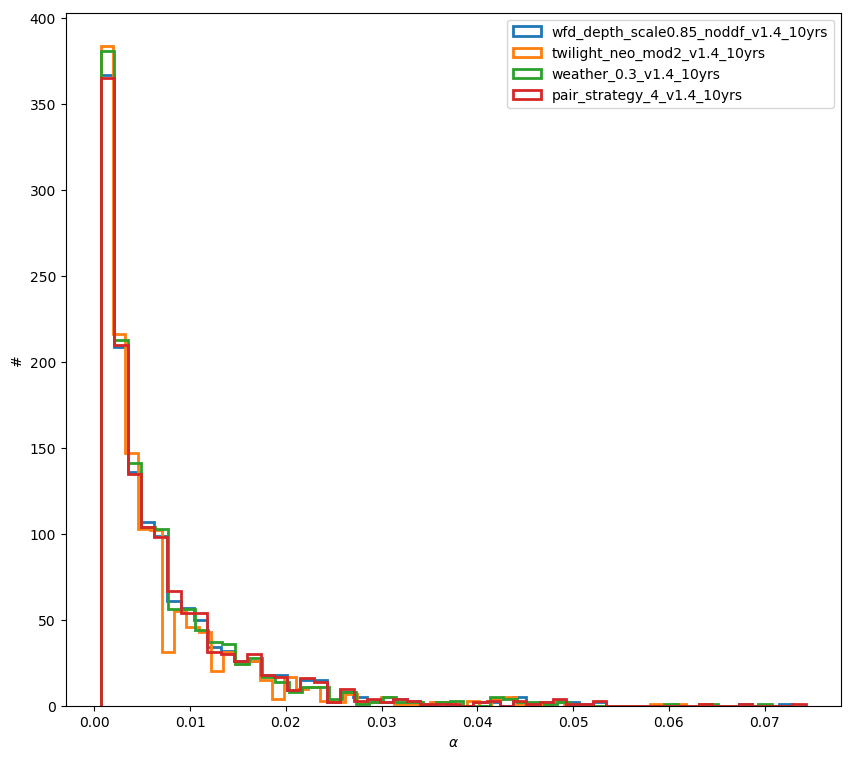

In [85]:
plt.figure(figsize=(10,9))
for key in bundleDicts.keys():
    plt.hist(alpha[key][np.where(alpha[key]!=0)],bins='auto', lw=2, histtype='step', label='{}'.format(key))
    plt.xlabel(r'$\alpha$')
    plt.ylabel('#')
    plt.legend()

### DISTANCE SIMULATION

In [112]:
dataout, cind_dist,H_dist,c_dist={},{},{},{}
for key in bundleDicts.keys():
    dataout[key]=pd.DataFrame(bundleDicts[key][(1,'confusionmetric')].metricValues[np.where(bundleDicts[key][(1,'confusionmetric')].metricValues.mask == False)])[0]
    cind_dist[key]= {}
    H_dist[key]= {}
    c_dist[key]= {}
    for mag in dataout[key][0].keys(): 
        cind_dist[key][mag] = []
        H_dist[key][mag] = []
        c_dist[key][mag] = []
    for i in range(len(dataout[key])):        
        if dataout[key][i]:
            for mag in dataout[key][i].keys():
                cind_dist[key][mag].append(dataout[key][i][mag]['num'])
                H_dist[key][mag].append(dataout[key][i][mag]['Hg'])
                c_dist[key][mag].append(dataout[key][i][mag]['g-r'])
    for mag in dataout[key][0].keys(): 
        cind_dist[key][mag]=np.hstack(np.array(cind_dist[key][mag])[np.isfinite(np.array(cind_dist[key][mag]))])
        H_dist[key][mag]=np.hstack(np.array(H_dist[key][mag])[np.isfinite(np.array(H_dist[key][mag]))])
        c_dist[key][mag]=np.hstack(np.array(c_dist[key][mag])[np.isfinite(np.array(c_dist[key][mag]))])
    

### DENSITY SIMULATION

In [108]:
dataout_dens, cind_dens,H_dens,c_dens={},{},{},{}
for key in bundleDicts.keys():
    dataout_dens[key]=pd.DataFrame(bundleDicts[key][(1,'confusionmetric')].metricValues[np.where(bundleDicts[key][(1,'confusionmetric')].metricValues.mask == False)])[0]
    cind_dens[key]= {}
    H_dens[key]= {}
    c_dens[key]= {}
    for mag in dataout_dens[key][0].keys(): 
        cind_dens[key][mag] = []
        H_dens[key][mag] = []
        c_dens[key][mag] = []
    for i in range(len(dataout_dens[key])):        
        if dataout_dens[key][i]:
            for mag in dataout_dens[key][i].keys():
                cind_dens[key][mag].append(dataout_dens[key][i][mag]['num'])
                H_dens[key][mag].append(dataout_dens[key][i][mag]['Hg'])
                c_dens[key][mag].append(dataout_dens[key][i][mag]['g-r'])
    for mag in dataout_dens[key][0].keys(): 
        cind_dens[key][mag]=np.hstack(np.array(cind_dens[key][mag])[np.isfinite(np.array(cind_dens[key][mag]))])
        H_dens[key][mag]=np.hstack(np.array(H_dens[key][mag])[np.isfinite(np.array(H_dens[key][mag]))])
        c_dens[key][mag]=np.hstack(np.array(c_dens[key][mag])[np.isfinite(np.array(c_dens[key][mag]))])
    

In [22]:
lam[key].keys()

dict_keys([0, 2, 4, 6, 8])

In [21]:
import seaborn as sn
import matplotlib as mpl

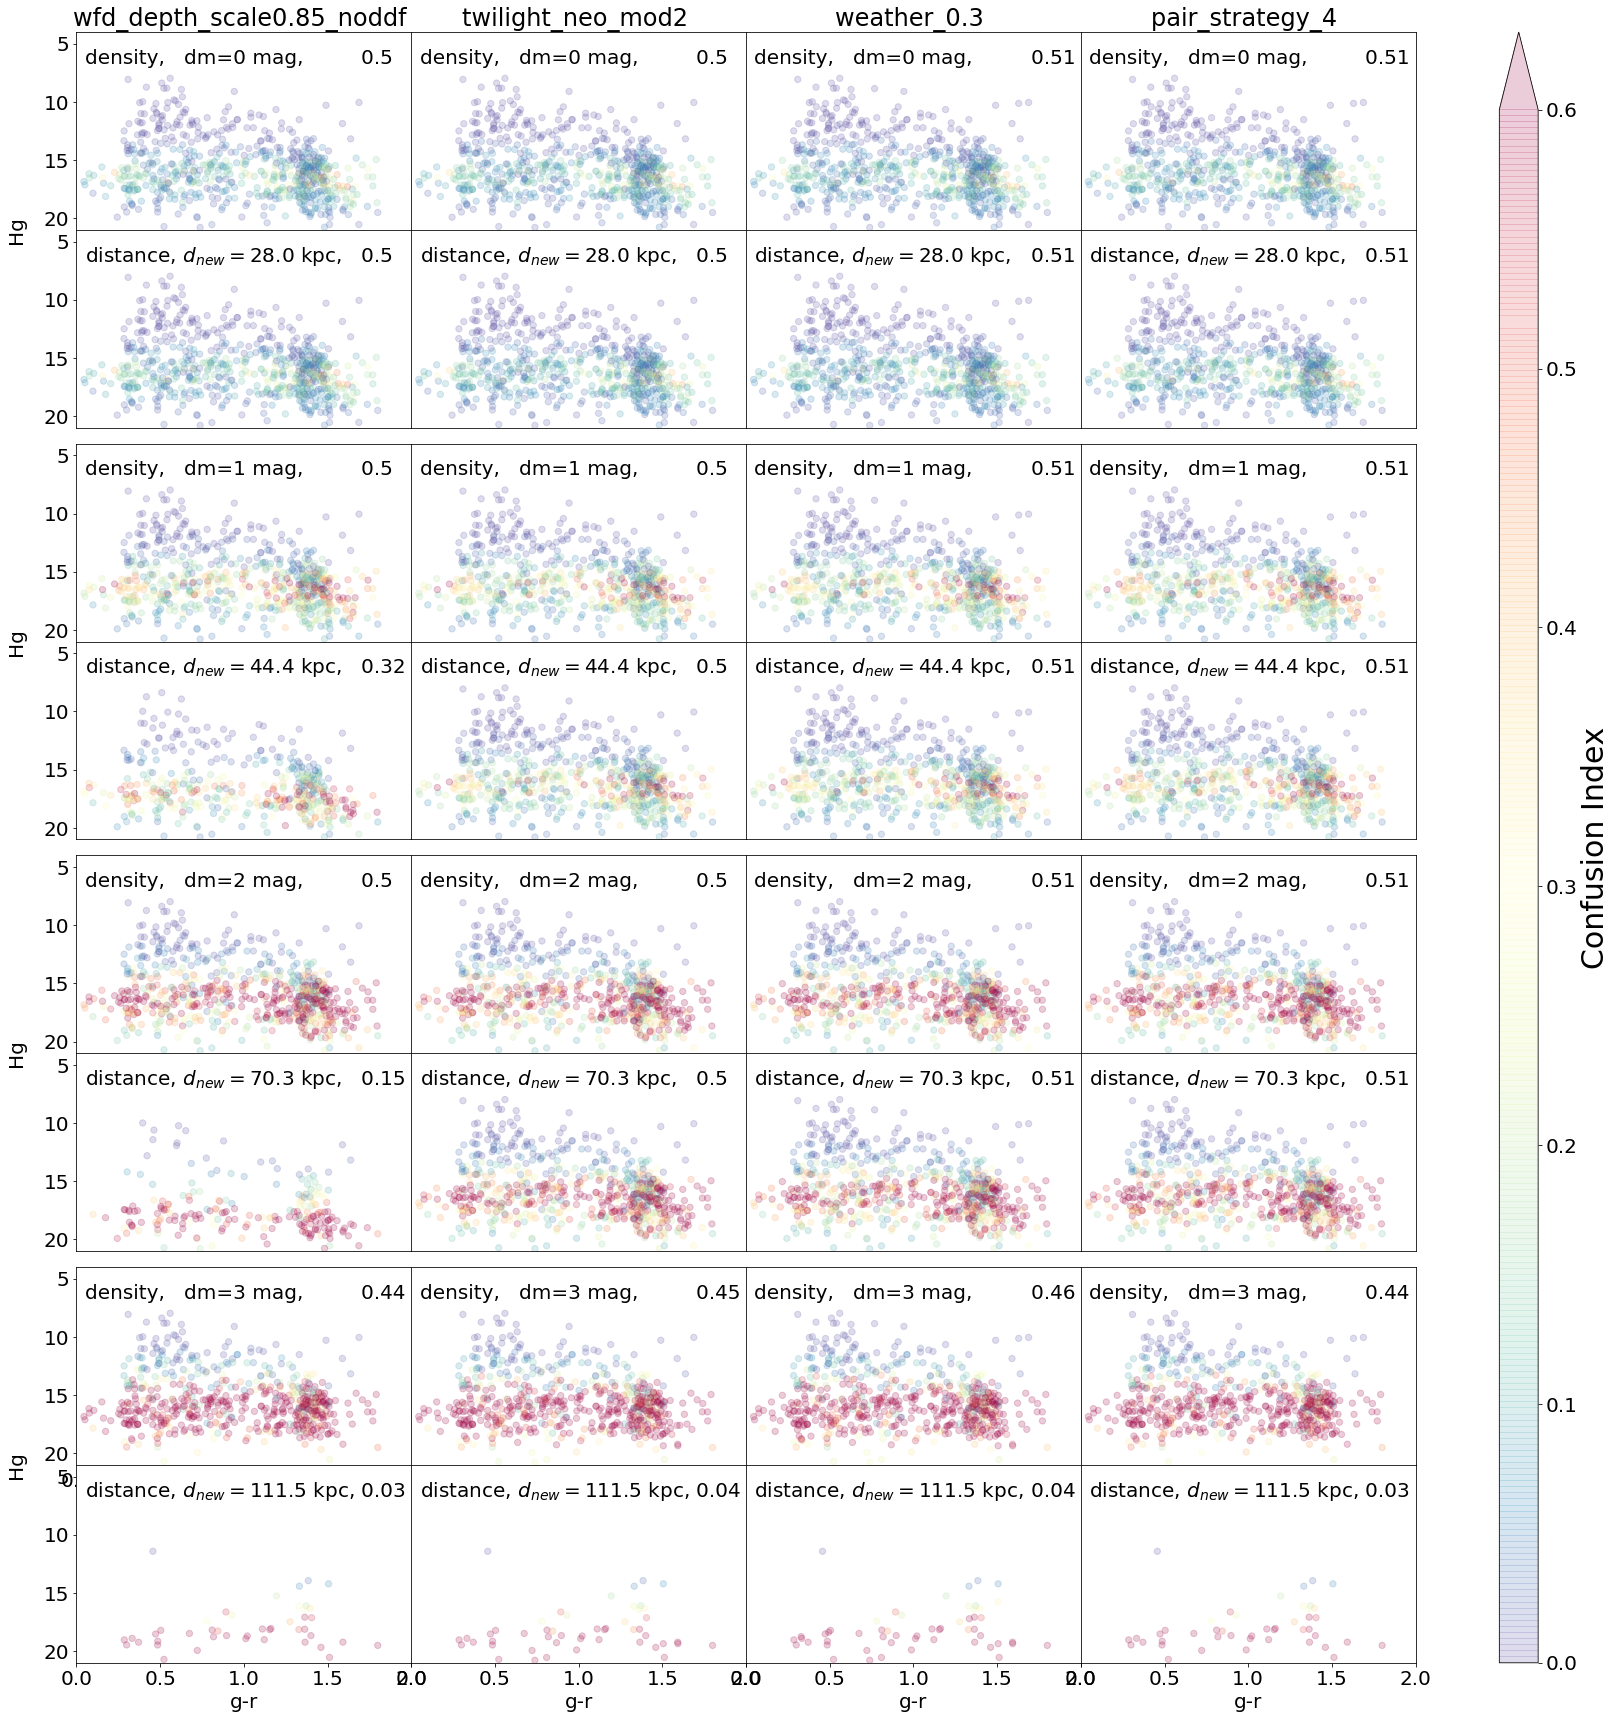

In [113]:
from itertools import product 
import matplotlib.gridspec as gridspec
mpl.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(30,30))
outer_grid = gridspec.GridSpec(4, 4, wspace=0.0, hspace=0.04)
for i, (mag, key) in enumerate(product([0,1,2,3],dbRuns[0:4])):
    n=key.split('_')
    n.remove('v1.4')
    n.remove('10yrs')
    sep='_'
    name= sep.join(n)
    inner_grid = gridspec.GridSpecFromSubplotSpec(
      2, 1, subplot_spec=outer_grid[i], wspace=0.0, hspace=0.0)
    for j, mode in enumerate(['density','distance']):
        ax = plt.Subplot(fig, inner_grid[j])
        
        if mode=='density'and i>=4 and i not in [0,4,8,12,13,14,15]:
            zero_mask = np.where(cind_dens[key][mag]==0)
            non_zero_mask = np.where(cind_dens[key][mag]!=0)
            plotdata=pd.DataFrame(np.matrix([H_dens[key][mag][non_zero_mask],c_dens[key][mag][non_zero_mask],cind_dens[key][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
            #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
            im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)
            
            im.annotate('{} '.format(np.round(1-np.size(H_dist[key][mag][zero_mask])/(np.size(H_dist[key][mag])),2)),[1.7,6.7], size=20)
            im.annotate('{},   dm={} mag,'.format(mode,mag),[0.05,6.7], size=20)
            im.invert_yaxis()
            im.set_ylabel('')
            im.set_xlabel('')
            im.get_xaxis().set_visible(False)
            im.get_yaxis().set_visible(False)
            fig.add_subplot(ax)
        if mode=='distance'and i>=4 and i not in [0,4,8,12,13,14,15]:
            zero_mask = np.where(cind_dens[key][mag]==0)
            non_zero_mask = np.where(cind_dens[key][mag]!=0)
            plotdata=pd.DataFrame(np.matrix([H_dens[key][mag][non_zero_mask],c_dens[key][mag][non_zero_mask],cind_dens[key][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
            #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
            im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)
            
            im.annotate('{} '.format(np.round(1-np.size(H_dist[key][mag][zero_mask])/(np.size(H_dist[key][mag])),2)),[1.7,6.7], size=20)
            im.annotate('{}, '.format(mode)  + r'$d_{new}=$'+'{} kpc,'.format(np.round(28*10**(mag/5),1)),[0.05,6.7], size=20)
            im.invert_yaxis()
            im.set_ylabel('')
            im.set_xlabel('')
            im.get_xaxis().set_visible(False)
            im.get_yaxis().set_visible(False)
            fig.add_subplot(ax)
            
        elif mode=='density'and i in [4,8]:
            zero_mask = np.where(cind_dens[key][mag]==0)
            non_zero_mask = np.where(cind_dens[key][mag]!=0)
            plotdata=pd.DataFrame(np.matrix([H_dens[key][mag][non_zero_mask],c_dens[key][mag][non_zero_mask],cind_dens[key][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
            #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
            im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)
            
            im.annotate('{} '.format(np.round(1-np.size(H_dens[key][mag][zero_mask])/(np.size(H_dens[key][mag])),2)),[1.7,6.7], size=20)
            im.annotate('{},   dm={} mag,'.format(mode,mag),[0.05,6.7], size=20)
            im.invert_yaxis()
            im.yaxis.set_label_coords(-0.15,0)
            im.set_ylabel('Hg')
            im.set_xlabel('')
            im.get_xaxis().set_visible(False)
            fig.add_subplot(ax)
        elif mode=='distance'and i in [4,8]:
            zero_mask = np.where(cind_dist[key][mag]==0)
            non_zero_mask = np.where(cind_dist[key][mag]!=0)
            plotdata=pd.DataFrame(np.matrix([H_dist[key][mag][non_zero_mask],c_dist[key][mag][non_zero_mask],cind_dist[key][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
            #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
            im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)
            
            im.annotate('{} '.format(np.round(1-np.size(H_dist[key][mag][zero_mask])/(np.size(H_dist[key][mag])),2)),[1.7,6.7], size=20)
            im.annotate('{}, '.format(mode)  + r'$d_{new}=$'+'{} kpc,'.format(np.round(28*10**(mag/5),1)),[0.05,6.7], size=20)
            im.invert_yaxis()
            im.yaxis.set_label_coords(-0.15,0)
            im.set_ylabel('')
            im.set_xlabel('')
            im.get_xaxis().set_visible(False)
            fig.add_subplot(ax)
        
        elif mode=='density' and i in [1,2,3]:
            zero_mask = np.where(cind_dens[key][mag]==0)
            non_zero_mask = np.where(cind_dens[key][mag]!=0)
            plotdata=pd.DataFrame(np.matrix([H_dens[key][mag][non_zero_mask],c_dens[key][mag][non_zero_mask],cind_dens[key][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
            #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
            im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2,title='{} '.format(name))
            
            im.annotate('{} '.format(np.round(1-np.size(H_dist[key][mag][zero_mask])/(np.size(H_dist[key][mag])),2)),[1.7,6.7], size=20)
            im.annotate('{},   dm={} mag,'.format(mode,mag),[0.05,6.7], size=20)
            im.invert_yaxis()
            im.set_ylabel('')
            im.set_xlabel('')
            im.get_xaxis().set_visible(False)
            im.get_yaxis().set_visible(False)
            fig.add_subplot(ax)
        elif mode=='distance' and i in [1,2,3]:
            zero_mask = np.where(cind_dist[key][mag]==0)
            non_zero_mask = np.where(cind_dist[key][mag]!=0)
            plotdata=pd.DataFrame(np.matrix([H_dist[key][mag][non_zero_mask],c_dist[key][mag][non_zero_mask],cind_dist[key][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
            #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
            im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)
            im.annotate('{} '.format(np.round(1-np.size(H_dist[key][mag][zero_mask])/(np.size(H_dist[key][mag])),2)),[1.7,6.7], size=20)
            im.annotate('{}, '.format(mode)  + r'$d_{new}=$'+'{} kpc,'.format(np.round(28*10**(mag/5),1)),[0.05,6.7], size=20)
            im.invert_yaxis()
            im.set_ylabel('')
            im.set_xlabel('')
            im.get_xaxis().set_visible(False)
            im.get_yaxis().set_visible(False)
            fig.add_subplot(ax)
        elif mode=='density' and i==0:
            zero_mask = np.where(cind_dens[key][mag]==0)
            non_zero_mask = np.where(cind_dens[key][mag]!=0)
            plotdata=pd.DataFrame(np.matrix([H_dens[key][mag][non_zero_mask],c_dens[key][mag][non_zero_mask],cind_dens[key][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
            #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
            im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2,title='{} '.format(name))
            
            im.annotate('{} '.format(np.round(1-np.size(H_dens[key][mag][zero_mask])/(np.size(H_dens[key][mag])),2)),[1.7,6.7], size=20)
            im.annotate('{},   dm={} mag,'.format(mode,mag),[0.05,6.7], size=20)
            im.yaxis.set_label_coords(-0.15,0)
            im.set_ylabel('Hg')
            im.set_xlabel('')
            im.invert_yaxis()
            im.get_xaxis().set_visible(False)
            fig.add_subplot(ax)
        elif mode=='distance' and i==0:
            zero_mask = np.where(cind_dist[key][mag]==0)
            non_zero_mask = np.where(cind_dist[key][mag]!=0)
            plotdata=pd.DataFrame(np.matrix([H_dist[key][mag][non_zero_mask],c_dist[key][mag][non_zero_mask],cind_dist[key][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
            #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
            im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)
            
            im.annotate('{} '.format(np.round(1-np.size(H_dist[key][mag][zero_mask])/(np.size(H_dist[key][mag])),2)),[1.7,6.7], size=20)
            im.annotate('{}, '.format(mode)  + r'$d_{new}=$'+'{} kpc,'.format(np.round(28*10**(mag/5),1)),[0.05,6.7], size=20)
            im.yaxis.set_label_coords(-0.15,0)
            im.set_ylabel('')
            im.set_xlabel('')
            im.invert_yaxis()
            im.get_xaxis().set_visible(False)
            fig.add_subplot(ax)
        elif mode=='density'and i==12:
            zero_mask = np.where(cind_dens[key][mag]==0)
            non_zero_mask = np.where(cind_dens[key][mag]!=0)
            plotdata=pd.DataFrame(np.matrix([H_dens[key][mag][non_zero_mask],c_dens[key][mag][non_zero_mask],cind_dens[key][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
            #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
            im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)
            
            im.annotate('{} '.format(np.round(1-np.size(H_dens[key][mag][zero_mask])/(np.size(H_dens[key][mag])),2)),[1.7,6.7], size=20)
            im.annotate('{},   dm={} mag,'.format(mode,mag),[0.05,6.7], size=20)
            im.invert_yaxis()
            im.yaxis.set_label_coords(-0.15,0)
            im.set_ylabel('Hg')
            im.set_xlabel('')
            fig.add_subplot(ax)
        if mode=='distance'and i==12:
            zero_mask = np.where(cind_dist[key][mag]==0)
            non_zero_mask = np.where(cind_dist[key][mag]!=0)
            plotdata=pd.DataFrame(np.matrix([H_dist[key][mag][non_zero_mask],c_dist[key][mag][non_zero_mask],cind_dist[key][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
            #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
            im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)
            
            im.annotate('{} '.format(np.round(1-np.size(H_dist[key][mag][zero_mask])/(np.size(H_dist[key][mag])),2)),[1.7,6.7], size=20)
            im.annotate('{}, '.format(mode)  + r'$d_{new}=$'+'{} kpc,'.format(np.round(28*10**(mag/5),1)),[0.05,6.7], size=20)
            im.invert_yaxis()
            im.yaxis.set_label_coords(-0.15,0)
            im.set_ylabel('')
            fig.add_subplot(ax)         
        elif mode== 'distance' and i in [13,14,15]:
            zero_mask = np.where(cind_dist[key][mag]==0)
            non_zero_mask = np.where(cind_dist[key][mag]!=0)
            plotdata=pd.DataFrame(np.matrix([H_dist[key][mag][non_zero_mask],c_dist[key][mag][non_zero_mask],cind_dist[key][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
            #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
            im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)
            im.annotate('{} '.format(np.round(1-np.size(H_dist[key][mag][zero_mask])/(np.size(H_dist[key][mag])),2)),[1.7,6.7], size=20)
            im.annotate('{}, '.format(mode)  + r'$d_{new}=$'+'{} kpc,'.format(np.round(28*10**(mag/5),1)),[0.05,6.7], size=20)
            im.set_ylabel('')
            im.invert_yaxis()
            im.get_yaxis().set_visible(False)
            fig.add_subplot(ax)
        elif mode== 'density' and i in [13,14,15]:
            zero_mask = np.where(cind_dens[key][mag]==0)
            non_zero_mask = np.where(cind_dens[key][mag]!=0)
            plotdata=pd.DataFrame(np.matrix([H_dens[key][mag][non_zero_mask],c_dens[key][mag][non_zero_mask],cind_dens[key][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
            #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
            im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)
            im.annotate('{} '.format(np.round(1-np.size(H_dist[key][mag][zero_mask])/(np.size(H_dist[key][mag])),2)),[1.7,6.7], size=20)
            im.annotate('{},   dm={} mag,'.format(mode,mag),[0.05,6.7], size=20)
            im.set_ylabel('')
            im.invert_yaxis()
            im.get_yaxis().set_visible(False)
            im.get_xaxis().set_visible(False)
            fig.add_subplot(ax)
        
all_axes = fig.get_axes()
fig.tight_layout()
cax,kw = mpl.colorbar.make_axes([ax for ax in all_axes], aspect=40)
cbar= plt.colorbar(all_axes[0].get_children()[0], extend= 'max',cax=cax,**kw)
cbar.ax.set_ylabel('Confusion Index', size=30)
fig.savefig("ConfunsionIndex_5yrs.png")
